In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

In [2]:
plt.style.use("../style1.mplstyle")

In [182]:
Nr = 100
Ns = 30

In [183]:
def assertParams(muMatrix,kMatrix,dTensor,delta,supplyVec):
    assert np.shape(muMatrix) == (Ns,Nr)
    assert np.shape(kMatrix) == (Ns,Nr)
    assert np.shape(dTensor) == (Ns,Nr,Nr)
    # assert np.shape(rVec) == (Nr,)
    assert np.shape(supplyVec) == (Nr,)

    assert np.all(supplyVec >= 0)
    assert delta > 0
    assert np.all(muMatrix >= 0)
    assert np.all(kMatrix > 0)
    assert np.all(dTensor >= 0)


@njit
def chemostat_dynamics(t, y, muMatrix, kMatrix, dTensor, delta, supplyVec):
    populations = y[:Ns]
    resources = y[Ns:]

    dpop = np.zeros(Ns,dtype=np.float64)
    dres = np.zeros(Nr,dtype=np.float64)

    resourceUptakes = np.sum(muMatrix*resources / (kMatrix + resources),axis=1)
    dpop = populations * (resourceUptakes - delta)

    multiplierMatrix = (muMatrix.T * populations).T * resources / (kMatrix + resources)
    uptake = np.sum(multiplierMatrix,axis=0)  
    
    for alpha in range(Nr):        
        leakage = np.sum(dTensor[:,alpha,:]*multiplierMatrix)

        # uptake = 0
        # for j in range(Ns):
        #     uptake += muMatrix[j,alpha]*populations[j]*resources[alpha]/ (kMatrix[j,alpha] + resources[alpha]) 
            
        dres[alpha] = delta*(supplyVec[alpha] - resources[alpha]) - uptake[alpha] + leakage

    return np.concatenate((dpop,dres))

def gvecFn(muMatrix,kMatrix,rVec):
    gvec = np.zeros(Ns)
    for i in range(Ns):
        for alpha in range(Nr):
            gvec[i] += muMatrix[i,alpha]*rVec[alpha] / (kMatrix[i,alpha] + rVec[alpha])
    return gvec

def fVectorFn(supplyVec,rVec,delta):
    return delta*(supplyVec - rVec)

def eMatrixFn(muMatrix,kMatrix,dTensor,rVec):
    eMatrix = np.zeros((Nr,Ns))
    for beta in range(Nr):
        for j in range(Ns):
            leakage = 0
            for alpha in range(Nr):
                leakage += dTensor[j,beta,alpha]*muMatrix[j,alpha]*rVec[alpha] / (kMatrix[j,alpha] + rVec[alpha])
            eMatrix[beta,j] = leakage + muMatrix[j,beta] * rVec[beta] / (kMatrix[j,beta] + rVec[beta])
    return eMatrix

def sMatrixFn(muMatrix,kMatrix,rVec):
    sMatrix = np.zeros((Nr,Ns))
    for beta in range(Nr):
        for j in range(Ns):
            sMatrix[beta,j] = muMatrix[j,beta] * kMatrix[j,beta] / (kMatrix[j,beta] + rVec[beta])**2
    return sMatrix

def dedrFn(muMatrix,kMatrix,dTensor,rVec):
    dedr = np.zeros((Nr,Nr,Ns))
    for beta in range(Nr):
        for alpha in range(Nr):
            for j in range(Ns):
                dedr[beta,alpha,j] = dTensor[j,beta,alpha]*muMatrix[j,alpha]*kMatrix[j,alpha] / (kMatrix[j,alpha] + rVec[alpha])**2
            if beta == alpha:
                dedr[beta,alpha,j] += muMatrix[j,alpha] *kMatrix[j,alpha]/ (kMatrix[j,alpha] + rVec[alpha])**2
    return dedr

def mMatrixFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec):
    mMatrix = np.zeros((Nr,Nr))
    eMatrix = eMatrixFn(muMatrix,kMatrix,dTensor,rVec)
    fVec = fVectorFn(supplyVec,rVec,delta)
    dedr = dedrFn(muMatrix,kMatrix,dTensor,rVec)

    eMatrixInv = np.linalg.pinv(eMatrix)

    for alpha in range(Nr):
        for beta in range(Nr):
            doublesum = 0
            for i in range(Ns):
                for gamma in range(Nr):
                    doublesum += dedr[alpha,beta,i]*eMatrixInv[i,gamma]*fVec[gamma]
            mMatrix[alpha,beta] = doublesum - delta
    return mMatrix

def glvParamsFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec):
    fVec = fVectorFn(supplyVec,rVec,delta)
    eMatrix = eMatrixFn(muMatrix,kMatrix,dTensor,rVec)
    sMatrix = sMatrixFn(muMatrix,kMatrix,rVec)
    mMatrix = mMatrixFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec)
    mInv = np.linalg.inv(mMatrix)

    growthVec = np.dot(sMatrix.T,np.dot(mInv,fVec))
    interactionMatrix = np.dot(-sMatrix.T,np.dot(mInv,eMatrix))
    return growthVec,interactionMatrix

In [184]:
muMatrix = np.random.gamma(0.2,0.5,(Ns,Nr))
kMatrix = np.random.lognormal(-1,2,(Ns,Nr))
# dTensor = np.zeros((Ns,Nr,Nr))
dTensor = 1/(1+np.random.lognormal(5,0.5,(Ns,Nr,Nr)))
# supplyVec = np.random.gamma(0,1,(Nr,))
supplyVec = np.full(Nr,6)
delta = 0.2

assertParams(muMatrix,kMatrix,dTensor,delta,supplyVec)

rVec = np.random.lognormal(np.mean(kMatrix)/np.mean(supplyVec),1,Nr)


In [192]:
growthVec,interactionMatrix = glvParamsFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec)

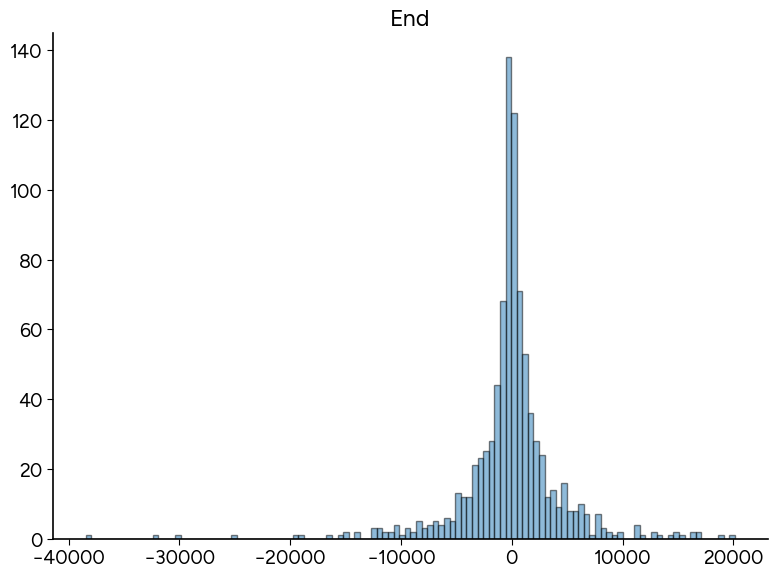

In [193]:
plt.hist(interactionMatrix.flatten(),bins="auto",color="tab:blue",alpha=0.5,edgecolor="black")

plt.title("End")
plt.show()

In [190]:
growthVec,interactionMatrix = glvParamsFn(muMatrix,kMatrix,dTensor,supplyVec,delta,supplyVec*0.9)

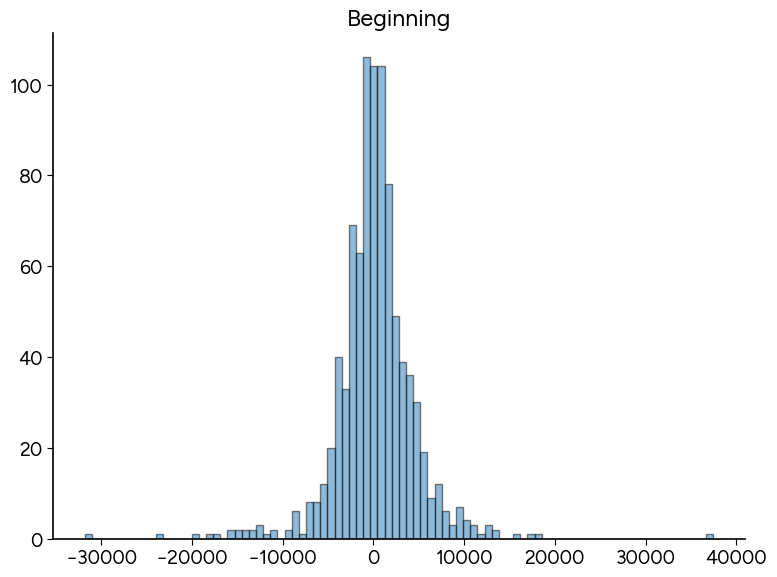

In [191]:
plt.hist(interactionMatrix.flatten(),bins="auto",color="tab:blue",alpha=0.5,edgecolor="black")

plt.title("Beginning")
plt.show()

In [171]:
dTensor =  np.zeros((Ns,Nr,Nr))
growthVec,interactionMatrix = glvParamsFn(muMatrix,kMatrix,dTensor,rVec,delta,supplyVec)

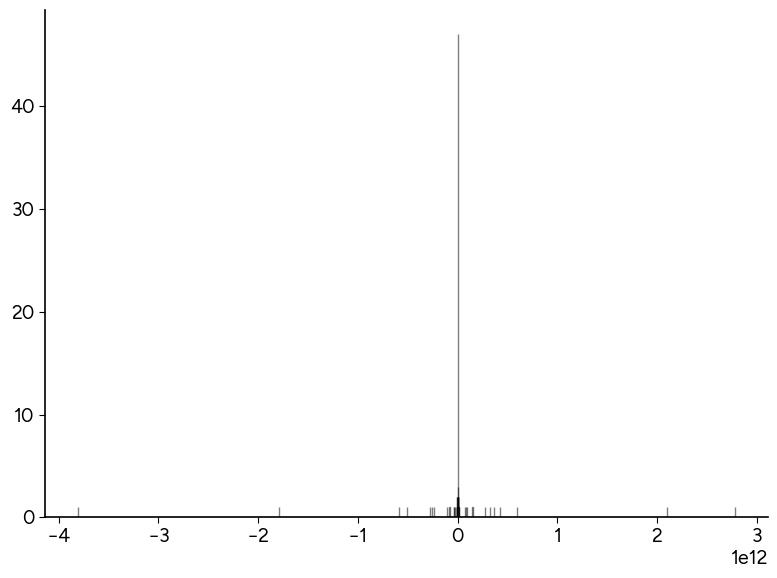

In [172]:
plt.hist(interactionMatrix.flatten(),bins="auto",color="tab:blue",alpha=0.5,edgecolor="black")

plt.show()

In [148]:
initialPopulations = np.random.uniform(0,1,Ns)
initialResources = np.random.uniform(0,1,Nr)

initialConditions = np.concatenate((initialPopulations,initialResources))

t = np.linspace(0,100,1000)

In [149]:
sol = integrate.solve_ivp(chemostat_dynamics,(0,t[-1]),initialConditions,args=(muMatrix, kMatrix, dTensor, delta, supplyVec),t_eval=t)

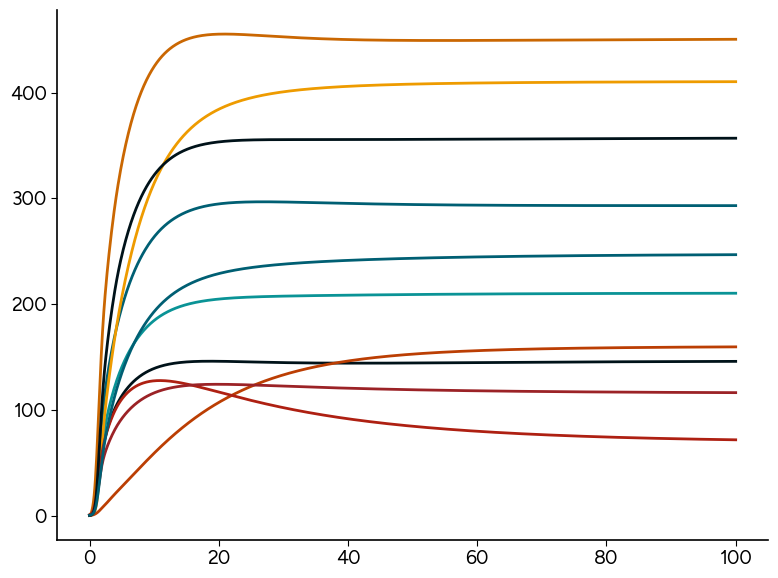

In [150]:
plt.plot(sol.t,sol.y[:Ns].T)

plt.show()

In [156]:
minresconc = np.min(sol.y[Ns:,-1])
maxresconc = np.max(sol.y[Ns:,-1])
bins = np.geomspace(minresconc,maxresconc,20)

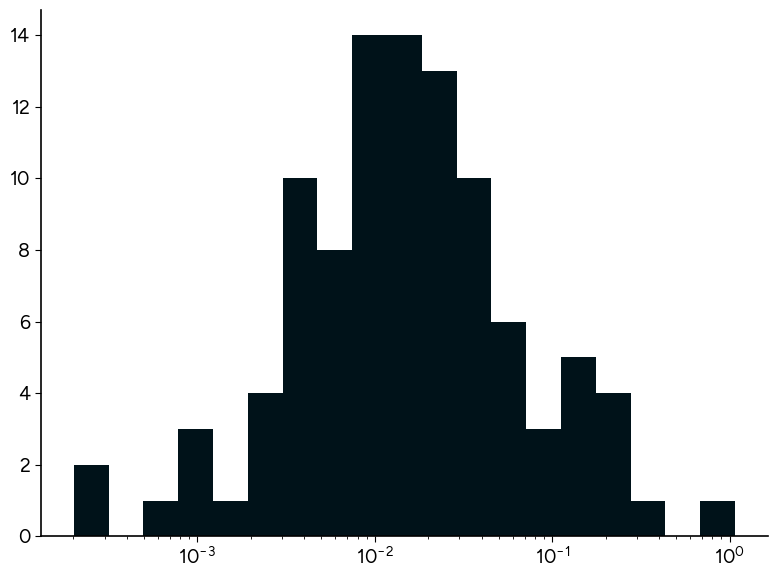

In [158]:
plt.hist(sol.y[Ns:,-1],bins=bins)

plt.xscale("log")
plt.show()